# Exploring Variational Autoencoders with fashion_mnist

---

#### CS344 Final Project
#### Calvin University
#### Spring 2020
#### isa3

# Vision

This final project is based around the topic of variational autoencoders, or VAES. VAES are a technology in the field of realistic image autogeneration, and additionally allow us to develop models which are capable of determining which images are similar to one another. I used this technology principally with Keras' `fashion_mnist` dataset, but additionally did testing on the `mnist` and `cifar10` datasets in an effort to improve the example VAE trained on `mnist` in Chapter 8.4 of F. Chollet's Deep Learning with Python Notebooks.

# Background

Variational autoencoders (VAEs) are a relatively new technology that allows for realistic image autogeneration using convolutional neural networks. Considered to have been discovered synchronously by Kingma and Welling in December 2013 and Rezende, Mohamed, and Wierstra in January 2014 \[1\], variational autoencoders are perhaps misnomered, since they only minimally resemble traditional autoencoders. Admittedly, they do have an "encoder" and a "decoder", but apart from that their background comes almost entirely from a mix of Bayesian statistics and deep learning \[2\]. 

Autoencoders are comprised of two major parts; an encoder, or a neural network which takes an input image and maps it to a latent vector space, and a decoder, which samples from the low-dimensional latent vector space and utilizes the sampled values to "decode" the values back into an image. Unlike traditional neural networks, autoencoders are trained by using the same images as both input data and target data \[1\]. Utilizing simple back-propagation, the variational autoencoder learns to both deconstruct the input data to meaningful values in the low-dimensional latent space, and to reconstruct these values into an output image similar to the input image. This is a form of unsupervised learning. Rather than attempting to classify the image correctly, VAEs attempt to group images within the latent space by similar characteristics \[2\].

![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)

                                                (Image source: [1])

To be clear, a latent vector space is a vector of latent variables, or variables whose values determine the characteristics of the image, but not explicitly. Due to their nature it's unclear exactly how latent variables affect the output, at least from an external perspective. In a multi-layer neural network, its entirely likely that the bottom layer latent variables actually control higher level latent variables. Perhaps, in the case of the mnist dataset, latent variables which might control the the angle and width of the pen stroke. The first layer of the decoder can learn how to decode the bottom level latent variables to feed appropriate values to these higher level latent variables, which in turn can be decoded into the actual image. Best of all, it's not necessary to worry about determining what these higher level latent variables represent. The neural network will learn what they represent from the data \[2\].

To visualize, this example from \[2\] illustrates how this set of d normally distributed variables can be rearranged into any distribution in d dimensions by mapping them through a sufficiently complicated function. This function is what will be learned by our decoder. Each layer will learn a different function, mapping latent variables to latent variables until finally it hits the last layer and generates an output image based on the previous layer.

<img src="img/function.png">

                                                (Image source: [2])

Autoencoders have been around for quite a while, so mapping an image to a latent vector space is really nothing new. However, traditional autoencoders turn out to be quite bad at meaningful compression, and additionally have uninteresting and less than useful latent spaces. Variational autoencoders, on the other hand, alter the model with some Bayesian statistics, forcing the model to create highly structured and continuous latent spaces. Traditional autoencoders simply turn an image into a single code in latent space. The image is compressed, but not in any way that's meaningful. VAEs, on the other hand, turn the image into the parameters of a statistical distribution with the encoder, and then sample from this distribution to get values for the decoder to work with. This means that the decoder will learn not only to decode the "code" itself back to the original image, but that it will also learn to decode similar codes back to similar images. Therefore, the stochasticity of the model results in a highly structured latent space, where similar images will be grouped and similarity between images can be calculated based on their proximity. Additionally, this forces the model to create a latent space with meaningful representations everywhere, improving robustness \[1\]. In this project's VAE, each image will be compressed into two latent variables: the mean and the variance of a simple Gaussian distribution.

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

                                                (Image source: [Chollet])

Here is Chollet's pseudocode schematic of how our VAE is structured.

In [3]:
# Encode the input into a mean and variance parameter
# z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
# z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
# reconstructed_img = decoder(z)

# Instantiate a model
# model = Model(input_img, reconstructed_img)

# Then train the model using 2 losses:
# a reconstruction loss and a regularization loss

Another virtue of VAEs is their modular nature. Being composed of an encoder and decoder, allows for three separate models to be utilized from training on a single set of data. For instance, with the fashion_mnist data set, after being trained the VAE can be used in its entirety, but the encoder and decoder can also be used individually. The encoder can be used on its own to take images and encode them into latent vectors, which can then be utilized as desired. The decoder, on the other hand, can be used to take latent vectors and generate images which are similar, but not identical, to the training data \[5\]. 

# Implementation

I began from the VAE example, trained on `mnist`, in Chapter 8.4 of Chollet's Deep Learning with Python Notebooks. My original goal was to swap in `fashion_mnist` for `mnist`, as `fashion_mnist` was designed to be a direct swap for `mnist` in terms of dataset and parameter sizes. While I expected a drop in performance with the change in dataset, the swap itself was designed to be easy. From there, I had hoped to fine-tune the VAE and its neural network in order to produce improved performance on the new dataset.

Unsurprisingly, the swap for `fashion_mnist` went extremely smoothly, but surprisingly, the expected performance drop was not as apparent as predicted. Using the original VAE with `fashion_mnist` substituted for `mnist`, the autogenerated image quality seemed reasonably satisfactory, and finding ways to decrease the overall loss was not simple in any way. However, through extensive experimentation and research, I modified the neural network to decrease the loss value at least somewhat and increase autogenerated image quality by a similar margin. The 3 major changes made to the original neural network which resulted in improved performance are listed below:

1. Removing the CustomVariationalLayer layer of Chollet's neural network in favor of utilizing the negative log likelihood as the loss function.

Chollet's neural network was critiqued in \[4\] for not taking advantage of Keras' modularity, and therefore being difficult to extend. One change suggested was to utilize the negative log likelihood as the loss function instead, interestingly equivalent to the sum of the `binary_crossentropy` loss function on the tensors of true and predicted values. While the typical `keras.losses.binary_crossentropy` method returns the mean of this function on the tensors, the sum is required to acquire the negative log likelihood, so I utilized \[4\]'s custom nll method to calculate the negative log likelihood as the loss. This resulted in a noticeable improvement in performance. The other main alteration resulting from this change was passing `x_train` and `x_test` as the target data to Model.fit(), since the loss was no longer taken care of within the neural network itself.

2. Substituting MaxPooling2D layers in favor of Conv2D layers with non-empty stride parameters.

Chollet's network contained a specific Conv2D where rather than utilizing the convolutional kernel on every potential unique set of pixels that he could, he passed in an argument to the `stride` parameter of shape (2,2), essentially applying the kernel to only every other unique set of pixels and reducing the shape of the processed image by half. I considered this an inefficient use of the pixel data, so I substituted in a MaxPooling2D layer. While the MaxPooling2D layer also reduces the shape of the processed image by half, it extracts more pertinent data by finding the maximum values of the max pooling kernel instead of simply applying the convolutional kernel to half as many values. Performance improved, and I additionally discovered shortly after that \[3\] used MaxPooling2D layers in their `cifar10` VAE, affirming my choice.

3. Adding a final MaxPooling2D layer to further refine the input image data.

Overfitting was not really much of a problem with VAEs. Due to their very nature being stochastic, even extensive training won't result in exact image replication. And additionally, the goal of the training is to produce a neural network that can autogenerate images that are extremely close to the test set; the input data is the target data. These ideas taken together indicate that extracting more useful features of the input image data and refining `z_mean` and `z_log_var` to be more representative would be strictly an improvement, with minimal risk of overfitting becoming an issue. Therefore, beyond substituting in a MaxPooling2D layer for the second Conv2D layer in the encoder, I additionally added in another MaxPooling2D layer to further refine the input image data. Performance for both loss and val_loss improved, without the two diverging. This indicated that overfitting was not yet a problem, despite the improvement in performance.

# Results

After refining my network on the fashion_mnist dataset, I decided that further testing was in order. The original `mnist`-oriented network provided by Chollet had generalized so well to `fashion_mnist` that I determined to test whether my network would offer improvements over Chollet's on the original `mnist` dataset as well.

In [1]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
from tensorflow.keras import backend as K
K.clear_session()

## Version 1: mnist, taken from Chollet's Deep Learning with Python Notebooks 8.4 

Here is the encoder network we will use: a very simple convnet which maps the input image `x` to two vectors, `z_mean` and `z_log_variance`.

In [83]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Here is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to 
generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In 
Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or else, in a custom 
layer).

In [84]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])


This is the decoder implementation: we reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final 
image output that has the same dimensions as the original `input_img`.

In [85]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up 
the loss by writing a custom layer with internally leverages the built-in `add_loss` layer method to create an arbitrary loss.

In [86]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])


Finally, we instantiate and train the model. Since the loss has been taken care of in our custom layer, we don't specify an external loss 
at compile time (`loss=None`), which in turns means that we won't pass target data during training (as you can see we only pass `x_train` 
to the model in `fit`).

In [87]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None, experimental_run_tf_function=False)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

hist = vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 32)   320         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_30[0][0]                  
___________________________________________________________________________________________

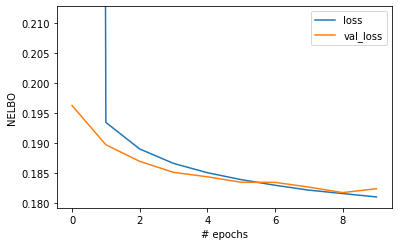

In [88]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

plt.show()

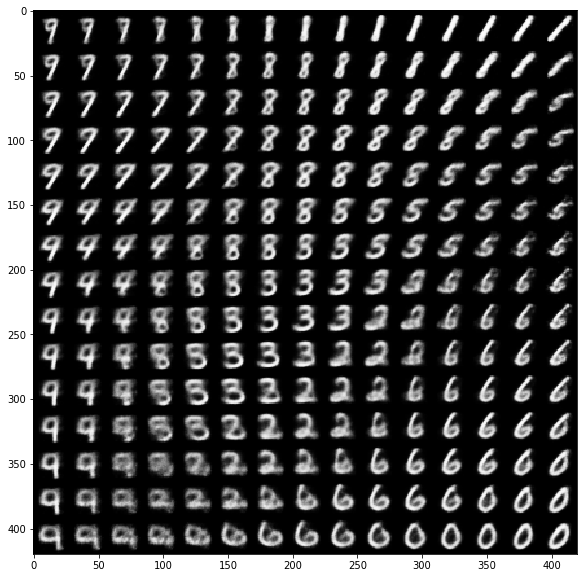

In [89]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another 
as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "four-ness", 
"one-ness", etc.

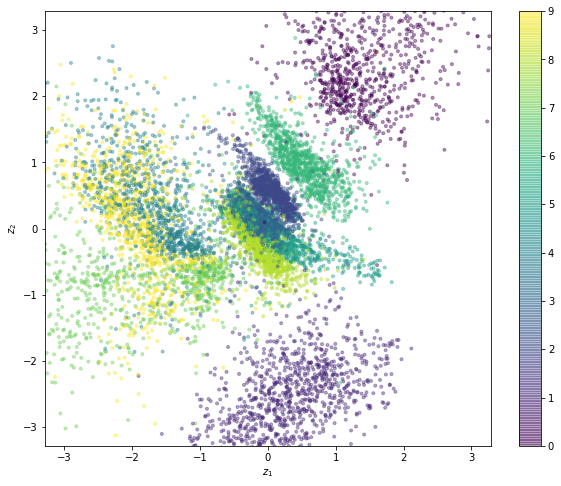

In [90]:
# deterministic test time encoder
test_encoder = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(10, 8))

cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)

ax.set_xlim(2.*norm.ppf((0.05, 0.95)))
ax.set_ylim(2.*norm.ppf((0.05, 0.95)))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.show()

## Version 2: mnist with updated encoder/decoder

The `mnist` dataset, trained on the VAE updated for `fashion_mnist`.

In [13]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [14]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [15]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [16]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [18]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img, z_decoded)
vae.compile(optimizer='rmsprop', loss=nll, experimental_run_tf_function=False)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

hist = vae.fit(x=x_train, y=x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       max_pooling2d[0][0]              
____________________________________________________________________________________________

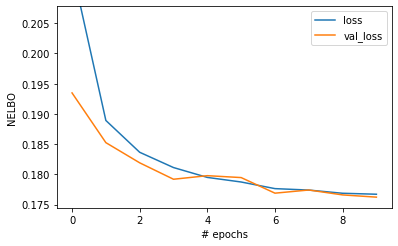

In [19]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

plt.show()

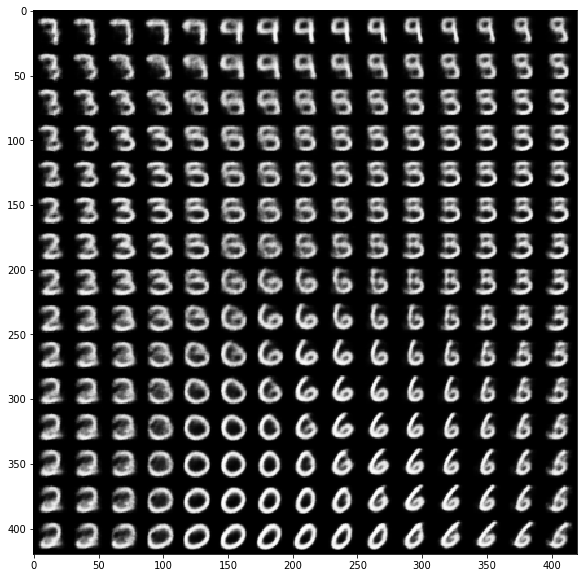

In [20]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

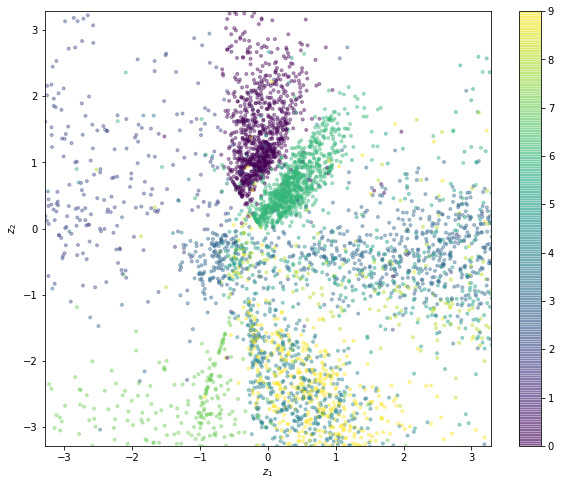

In [21]:
# deterministic test time encoder
test_encoder = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(10, 8))

cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)

ax.set_xlim(2.*norm.ppf((0.05, 0.95)))
ax.set_ylim(2.*norm.ppf((0.05, 0.95)))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.show()

### Results:

---

It's hard to determine which network performs better on the `mnist` dataset. Both `loss` and `val_loss` have been improved by approximately .005 by my network, but it's hard to say how much of a difference that makes. Comparing the latent space representations isn't easy, since there's no guarantee that both runs will learn similar representations, and both seem strong in different ways. Chollet's representation seems consistently blurred, and never particularly well-defined, but at least is consistently discernable. My representation doesn't seem as consistent, but has a few very well defined representation points that Chollet's can't seem to match. The 2D plot of the encoder's predictions is also interesting. Chollet's seems to have more clearly defined boundaries between most categories, but also doesn't fill the whole latent space as well. 

## Version 3: fashion_mnist with Chollet's VAE

This is the network the project began with, on the `fashion_mnist` dataset instead of the `mnist` dataset. While its performance certainly isn't bad, comparing the results between this network and the updated version should illustrate the improvements made.

In [101]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [102]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [103]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [104]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [105]:
from tensorflow.keras.datasets import fashion_mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None, experimental_run_tf_function=False)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

hist = vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 28, 28, 32)   320         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_40[0][0]                  
___________________________________________________________________________________________

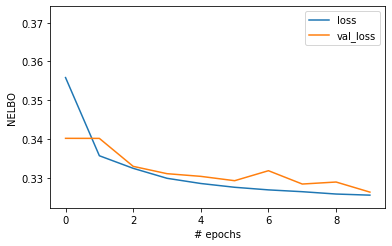

In [106]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

plt.show()

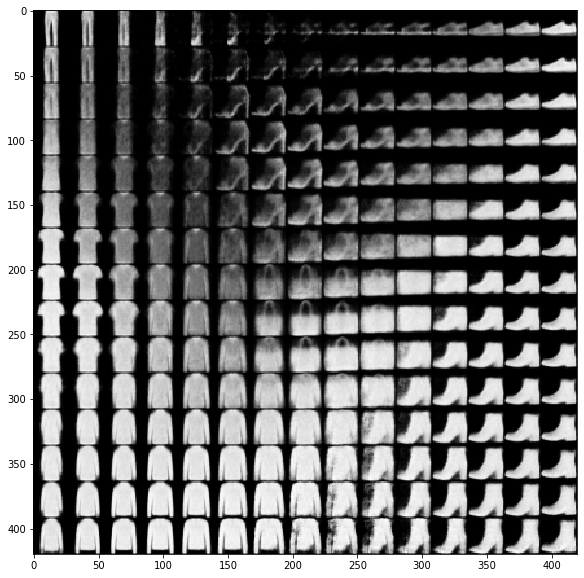

In [107]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

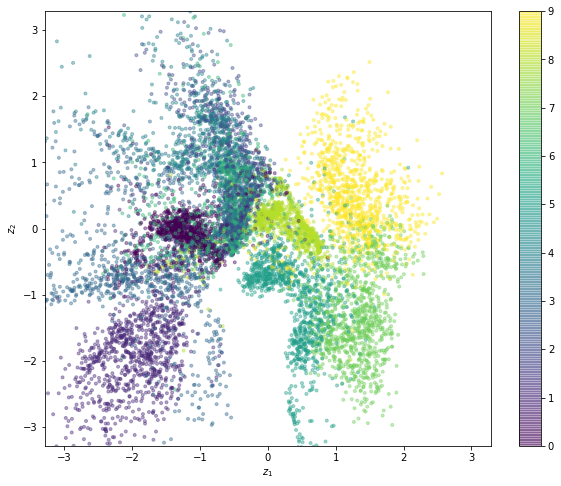

In [108]:
# deterministic test time encoder
test_encoder = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(10, 8))

cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)

ax.set_xlim(2.*norm.ppf((0.05, 0.95)))
ax.set_ylim(2.*norm.ppf((0.05, 0.95)))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.show()

## Version 4: fashion_mnist with updated encoder/decoder

Chollet's VAE which I have fine-tuned and altered for `fashion_mnist`, training and testing on `fashion_mnist`.

In [22]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [23]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [24]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [25]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [26]:
from tensorflow.keras.datasets import fashion_mnist

vae = Model(input_img, z_decoded)
vae.compile(optimizer='rmsprop', loss=nll, experimental_run_tf_function=False)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

hist = vae.fit(x=x_train, y=x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       max_pooling2d_2[0][0]            
____________________________________________________________________________________________

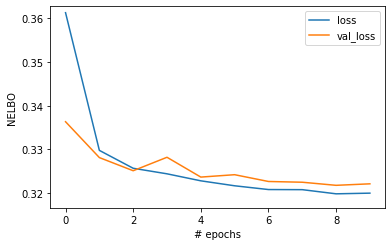

In [27]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

plt.show()

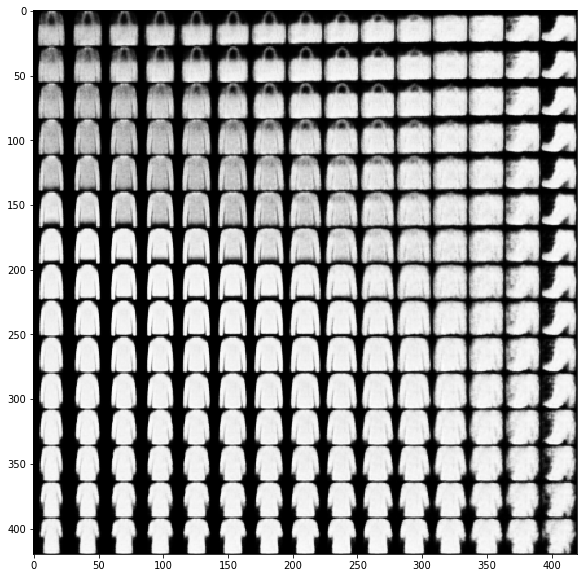

In [28]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

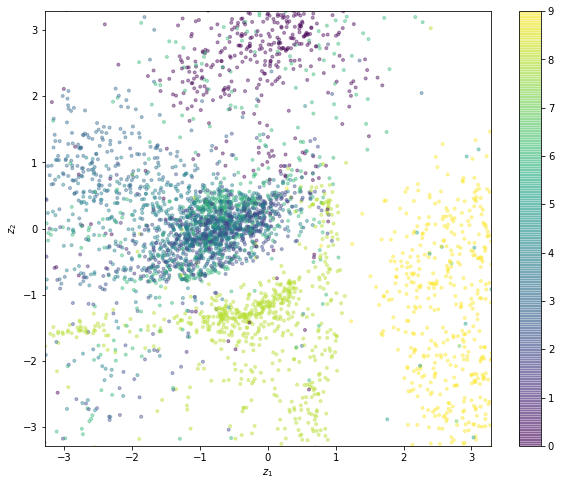

In [29]:
# deterministic test time encoder
test_encoder = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(10, 8))

cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)

ax.set_xlim(2.*norm.ppf((0.05, 0.95)))
ax.set_ylim(2.*norm.ppf((0.05, 0.95)))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.show()

### Results

---

I argue that my convolutional neural network is superior to Chollet's for the fashion_mnist dataset. With a lower `loss` by .56 and a lower `val_loss` by .43, there is at least some loss improvement for my network. Additionally, with Chollet's decoder representation of the latent space, there is a large, dark gap in the area between high heels and pants, whereas no such gap exists in my network's decoder representation of the latent space. This could admittedly be a symptom of high heels in general; while most examples in `fashion_mnist` are essentially shapes entirely filled in with white or black, high heels are an exception to this due to the strap of the shoe. This anomaly could confuse the VAE's training, and high heels are not present on my representation. Finally, my encoder's representation of the dataset's test z values within the latent space seems superior to Chollet's. Both representations have issues with various datasets intertwining with one another, but mine spreads throughout the entirety of the latent space, and additionally appears less intertwined

## Version 4: cifar10 with slightly adjusted encoder

Optimistically, I decided to slightly adjust my network to allow for `cifar10`'s 32x32 RGB images and run it on my dataset.

In [72]:
img_shape = (32, 32, 3)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [73]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [74]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [75]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [78]:
from tensorflow.keras.datasets import cifar10

In [79]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='rmsprop', loss=nll, experimental_run_tf_function=False)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
# x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
# x_test = x_test.reshape(x_test.shape + (1,))
temp = np.empty(y_test.size)
for i in range(0,y_test.size):
    temp[i] = y_test[i][0]
y_test = temp

hist = vae.fit(x=x_train, y=x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 32, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_10[0][0]           
___________________________________________________________________________________________

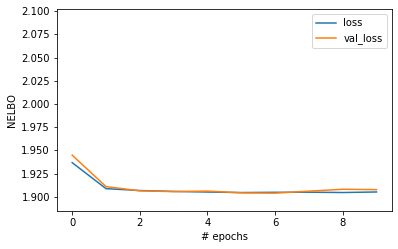

In [80]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

plt.show()

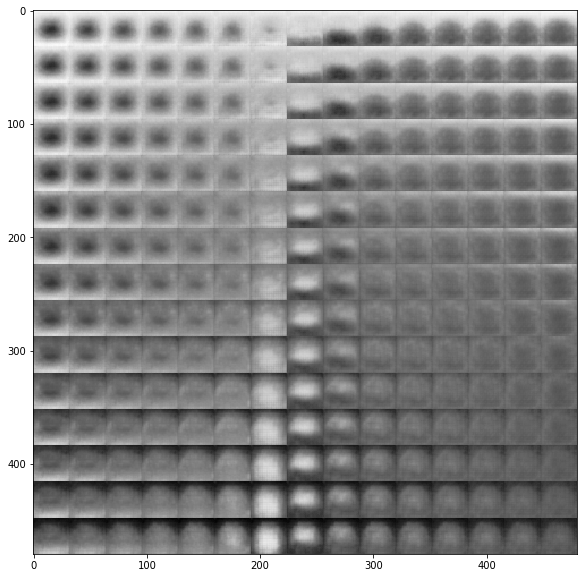

In [81]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

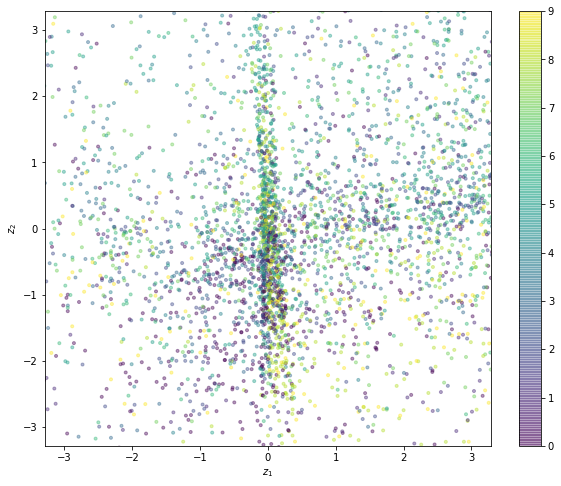

In [82]:
# deterministic test time encoder
test_encoder = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(10, 8))

cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)

ax.set_xlim(2.*norm.ppf((0.05, 0.95)))
ax.set_ylim(2.*norm.ppf((0.05, 0.95)))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.show()

### Results

---

Overall, this did not result in well-generated images. The loss remained incredibly high throughout the duration of the training, and the visualizations reflected it. Despite running for 10 epochs, the graphs of `loss` and `val_loss` barely budged. The representation of the decoder working on the latent space is clearly indicative that there *are* differences between the reconstructed images, but beyond that the reconstructions are so poor they're essentially just different types of blurs. And finally, the encoder has placed categories all over the latent space, with very little pattern or distinction. Either my network needs to be very much adjusted, or the `cifar10` dataset is simply incompatible with VAEs. Given that \[3\] tried out a VAE on the `cifar10` dataset and at least acquired somewhat better results, I'd be interested in reimplementing their convolutional neural network and seeing if I could improve it as a future project.

# Implications

In terms of social and ethical implications, VAES and image autogeneration have some rather foreboding potential. If one could use a network to autogenerate any type of image they'd like, generating a realistic looking but false image in order to blackmail or slander would not be remotely difficult. Whenever technology is used to tell a lie that is difficult to discern from the truth, we should always be careful about how far we're willing to trust it to bring us. Generating simple images that look like clothing is quite harmless, but as this technology improves more sinister utilities could be unlocked.

On a more optimistic note, the difficulty my network had in generating a good imitation when trained on the cifar10 dataset indicates that this technology may need to be significantly more refined before it poses any sort of threat like the ones outlined. However, with more state-of-the-art neural networks, processing power, and extensive and detailed datasets, dangers similar to the ones above are significantly closer to being a reality. While this technology is still in its infantile stages, at only seven years since its introduction, we should consider whether we want to raise it to full maturity.

# References

1. Chollet François, Deep learning with Python Notebooks. Shelter Island, NY: Manning Publications Co., 2018.

2. C. Doersch, “Tutorial on Variational Autoencoders,” arXiv.org, 16-Aug-2016. [Online]. Available: https://arxiv.org/pdf/1606.05908.pdf. [Accessed: 18-May-2020].

3. R. Dwivedi and O. Ocal, “Naturalistic Image Synthesis Using Variational Auto-Encoder,” Naturalistic Image Synthesis Using Variational Auto-Encoder, Dec-2016. [Online]. Available: https://bcourses.berkeley.edu/files/70257161/download?download_frd=1. [Accessed: 15-May-2020].

4. L. C. Tiao, “A Tutorial on Variational Autoencoders with a Concise Keras Implementation,” Louis Tiao, 13-Jan-2018. [Online]. Available: https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/. [Accessed: 18-May-2020].

5. “Variational autoencoder,” Keras Documentation. [Online]. Available: https://keras.io/examples/variational_autoencoder/. [Accessed: 20-May-2020].